In [12]:
import numpy as np

def GetCharMap(seq):
    invcharmap = []
    for s in seq:
        for c in s:
            if c not in invcharmap:
                invcharmap += c
    invcharmap = sorted(invcharmap)
    charmap = {}
    count = 0
    for c in invcharmap:
        charmap[c] = count
        count += 1
    return charmap,invcharmap

def seq2oh(Seqs,charmap):
    Onehot = []
    Length = len(Seqs[0])
    for i in range(len(Seqs)):
        line = np.zeros([Length,len(charmap)],dtype = 'float32')
        for j in range(Length):
            line[j,charmap[Seqs[i][j]]] = 1
        Onehot.append(line)
    Onehot = np.array(Onehot)
    return Onehot

def oh2seq(oh,invcharmap):
    Seqs = []
    for i in range(oh.shape[0]):
        seq = str()
        for j in range(oh.shape[1]):
            seq = seq + invcharmap[np.argmax(oh[i,j,:])]
        Seqs.append(seq)
    return Seqs

def saveseq(filename,seq):
    f = open(filename,'w')
    for i in range(len(seq)):
#        f.write('>'+str(i)+'\n')
        f.write(seq[i]+'\n')
    f.close()
    return

def load_seq_data(filename):
    seq = []
    with open(filename,'r') as f:
        for l in f:
            if l[0] == '>' or l[0] == '#':
                continue
            seq.append(str.strip(l))
    charmap,invcharmap = GetCharMap(seq)
    oh = seq2oh(seq,charmap)
    return oh,charmap,invcharmap

dataset, charmap,invcharmap = load_seq_data('rbs_seqs.fasta')
# dataset = np.expand_dims(dataset,3)
print(charmap)
# dataset = np.reshape(dataset,(4501,30,4))
print(dataset[0])
print(dataset.shape)

{'A': 0, 'C': 1, 'G': 2, 'T': 3}
[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]
(4536, 30, 4)


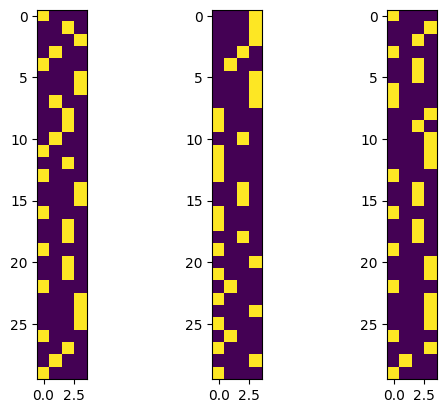

In [13]:
import matplotlib.pyplot as plt
# plt.figure(figsize = (2,4))
plt.subplot(131)
plt.imshow(dataset[0])
plt.subplot(132)
plt.imshow(dataset[1])
plt.subplot(133)
plt.imshow(dataset[2])
plt.show()

In [14]:
# 包
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
#导入包
import matplotlib.pyplot as plt # plt 用于显示图片
import matplotlib.image as mpimg # mpimg 用于读取图片
import numpy as np


# 设备配置
# torch.cuda.set_device(0) # 这句用来设置pytorch在哪块GPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 如果没有文件夹就创建一个文件夹
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# 超参数设置
# Hyper-parameters
image_size = 120  # 784
h_dim = 400
z_dim = 20
num_epochs = 1000
batch_size = 8
learning_rate = 1e-3

# dataset = torchvision.datasets.MNIST(root='../../../data/minist',
#                                      train=True,
#                                      transform=transforms.ToTensor(),
#                                      download=True)

# 数据加载器
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

# VAE model
class VAE(nn.Module):           #784
    def __init__(self, image_size=120, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim) # 均值 向量
        self.fc3 = nn.Linear(h_dim, z_dim) # 保准方差 向量
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    # 编码过程
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    # 随机生成隐含向量
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    # 解码过程
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    # 整个前向传播过程：编码-》解码
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

# 实例化一个模型
model = VAE().to(device)

# 创建优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

C:\Users\86158\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
C:\Users\86158\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/100], Step [10/567], Reconst Loss: 551.0598, KL Div: 4.5696
Epoch[1/100], Step [20/567], Reconst Loss: 510.3160, KL Div: 7.6179
Epoch[1/100], Step [30/567], Reconst Loss: 498.9081, KL Div: 1.4177
Epoch[1/100], Step [40/567], Reconst Loss: 515.9573, KL Div: 0.6878
Epoch[1/100], Step [50/567], Reconst Loss: 499.1377, KL Div: 0.8394
Epoch[1/100], Step [60/567], Reconst Loss: 493.8040, KL Div: 0.9292
Epoch[1/100], Step [70/567], Reconst Loss: 497.8127, KL Div: 0.7961
Epoch[1/100], Step [80/567], Reconst Loss: 489.5109, KL Div: 0.9542
Epoch[1/100], Step [90/567], Reconst Loss: 507.3269, KL Div: 1.5716
Epoch[1/100], Step [100/567], Reconst Loss: 512.9197, KL Div: 1.9418
Epoch[1/100], Step [110/567], Reconst Loss: 494.0969, KL Div: 2.0848
Epoch[1/100], Step [120/567], Reconst Loss: 490.4692, KL Div: 1.5708
Epoch[1/100], Step [130/567], Reconst Loss: 506.9152, KL Div: 2.5037
Epoch[1/100], Step [140/567], Reconst Loss: 511.7076, KL Div: 4.1542
Epoch[1/100], Step [150/567], Reconst Loss:

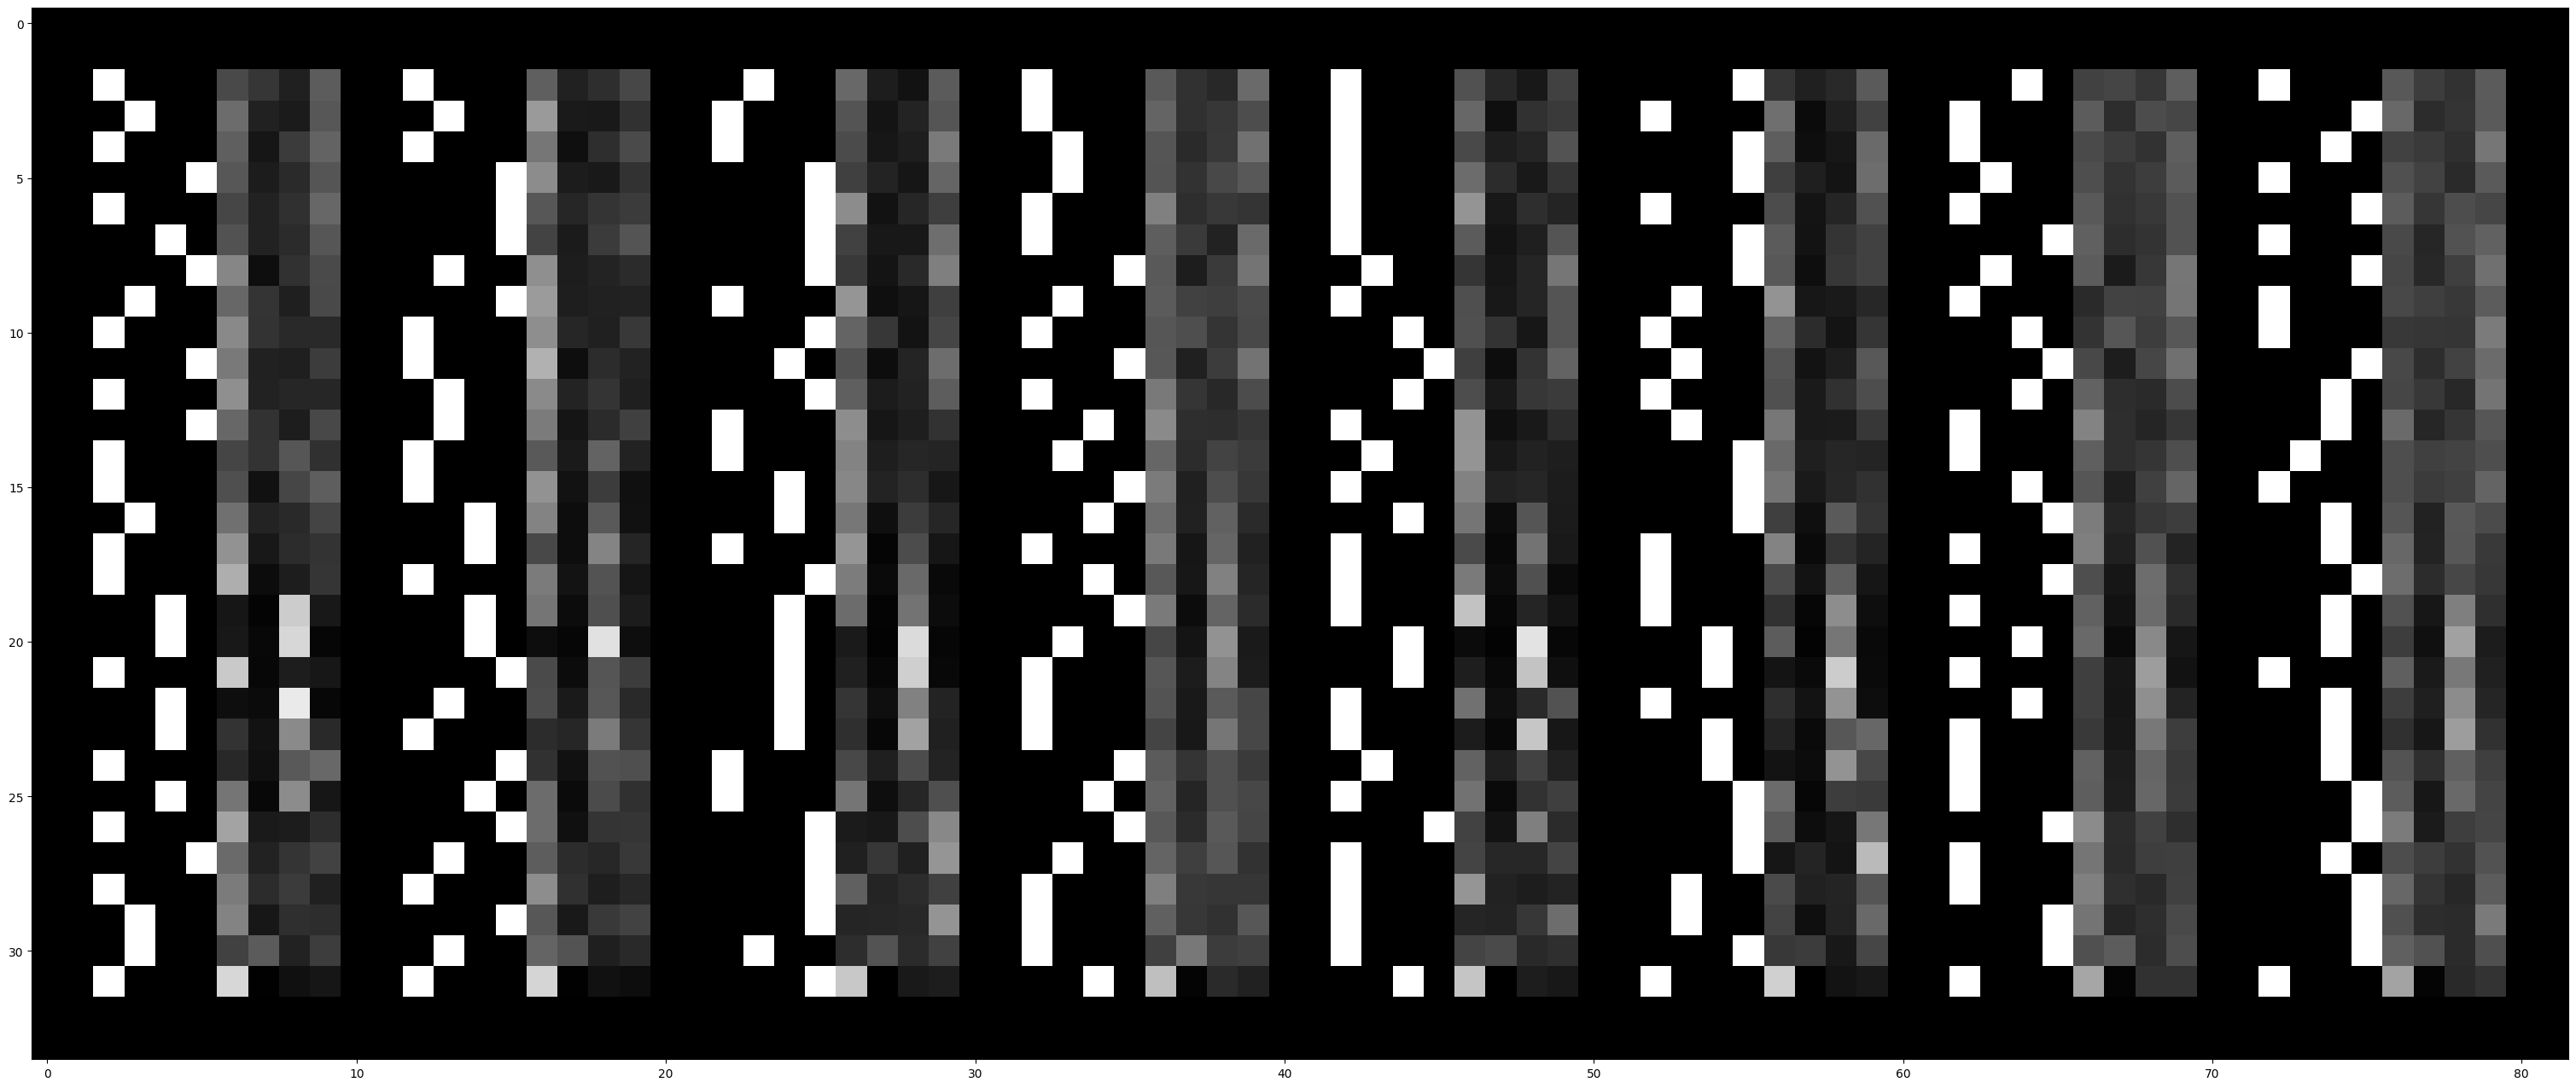

Epoch[2/100], Step [10/567], Reconst Loss: 480.6967, KL Div: 21.0985
Epoch[2/100], Step [20/567], Reconst Loss: 469.7521, KL Div: 23.0574
Epoch[2/100], Step [30/567], Reconst Loss: 492.6393, KL Div: 20.2911
Epoch[2/100], Step [40/567], Reconst Loss: 456.1303, KL Div: 20.4432
Epoch[2/100], Step [50/567], Reconst Loss: 491.3288, KL Div: 24.8690
Epoch[2/100], Step [60/567], Reconst Loss: 481.1105, KL Div: 21.6015
Epoch[2/100], Step [70/567], Reconst Loss: 505.3520, KL Div: 20.3582
Epoch[2/100], Step [80/567], Reconst Loss: 458.8013, KL Div: 23.9333
Epoch[2/100], Step [90/567], Reconst Loss: 473.9031, KL Div: 21.8175
Epoch[2/100], Step [100/567], Reconst Loss: 480.1918, KL Div: 20.9150
Epoch[2/100], Step [110/567], Reconst Loss: 449.7599, KL Div: 23.5564
Epoch[2/100], Step [120/567], Reconst Loss: 451.3566, KL Div: 26.9373
Epoch[2/100], Step [130/567], Reconst Loss: 449.1437, KL Div: 24.6123
Epoch[2/100], Step [140/567], Reconst Loss: 458.2640, KL Div: 24.2576
Epoch[2/100], Step [150/567],

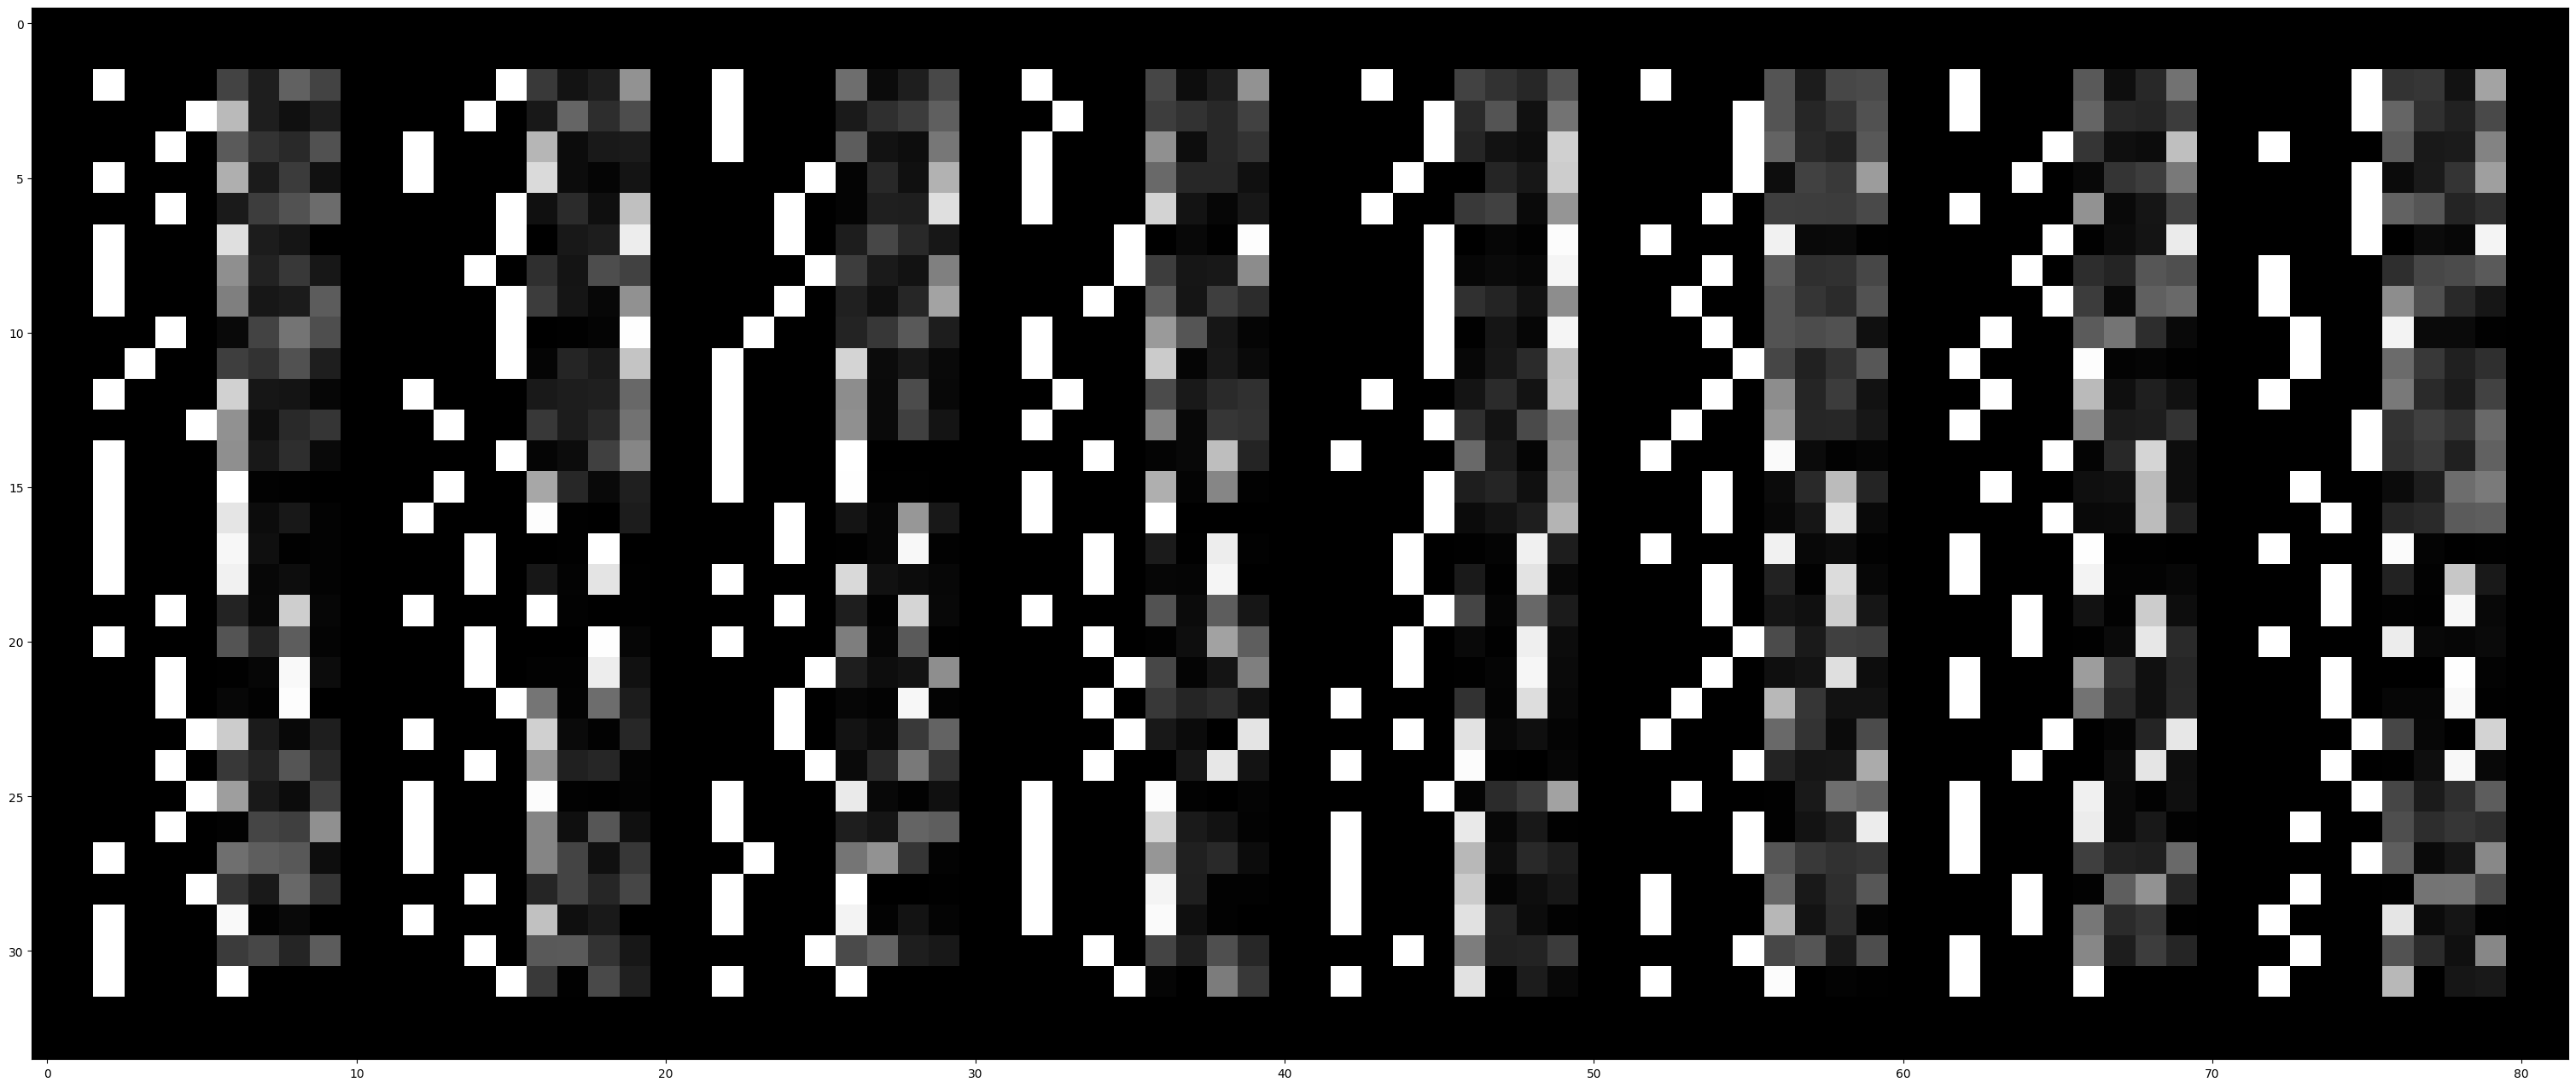

Epoch[27/100], Step [10/567], Reconst Loss: 336.0341, KL Div: 103.6451
Epoch[27/100], Step [20/567], Reconst Loss: 321.4178, KL Div: 105.0424
Epoch[27/100], Step [30/567], Reconst Loss: 364.7031, KL Div: 106.7137
Epoch[27/100], Step [40/567], Reconst Loss: 366.7676, KL Div: 106.6642
Epoch[27/100], Step [50/567], Reconst Loss: 332.7847, KL Div: 114.9767
Epoch[27/100], Step [60/567], Reconst Loss: 338.6232, KL Div: 113.2648
Epoch[27/100], Step [70/567], Reconst Loss: 336.0534, KL Div: 111.5676
Epoch[27/100], Step [80/567], Reconst Loss: 336.5078, KL Div: 104.6499
Epoch[27/100], Step [90/567], Reconst Loss: 361.8223, KL Div: 101.3806
Epoch[27/100], Step [100/567], Reconst Loss: 351.3237, KL Div: 105.8614
Epoch[27/100], Step [110/567], Reconst Loss: 341.2041, KL Div: 109.7751
Epoch[27/100], Step [120/567], Reconst Loss: 348.7590, KL Div: 105.2818
Epoch[27/100], Step [130/567], Reconst Loss: 298.7731, KL Div: 107.1919
Epoch[27/100], Step [140/567], Reconst Loss: 384.3809, KL Div: 100.9143
E

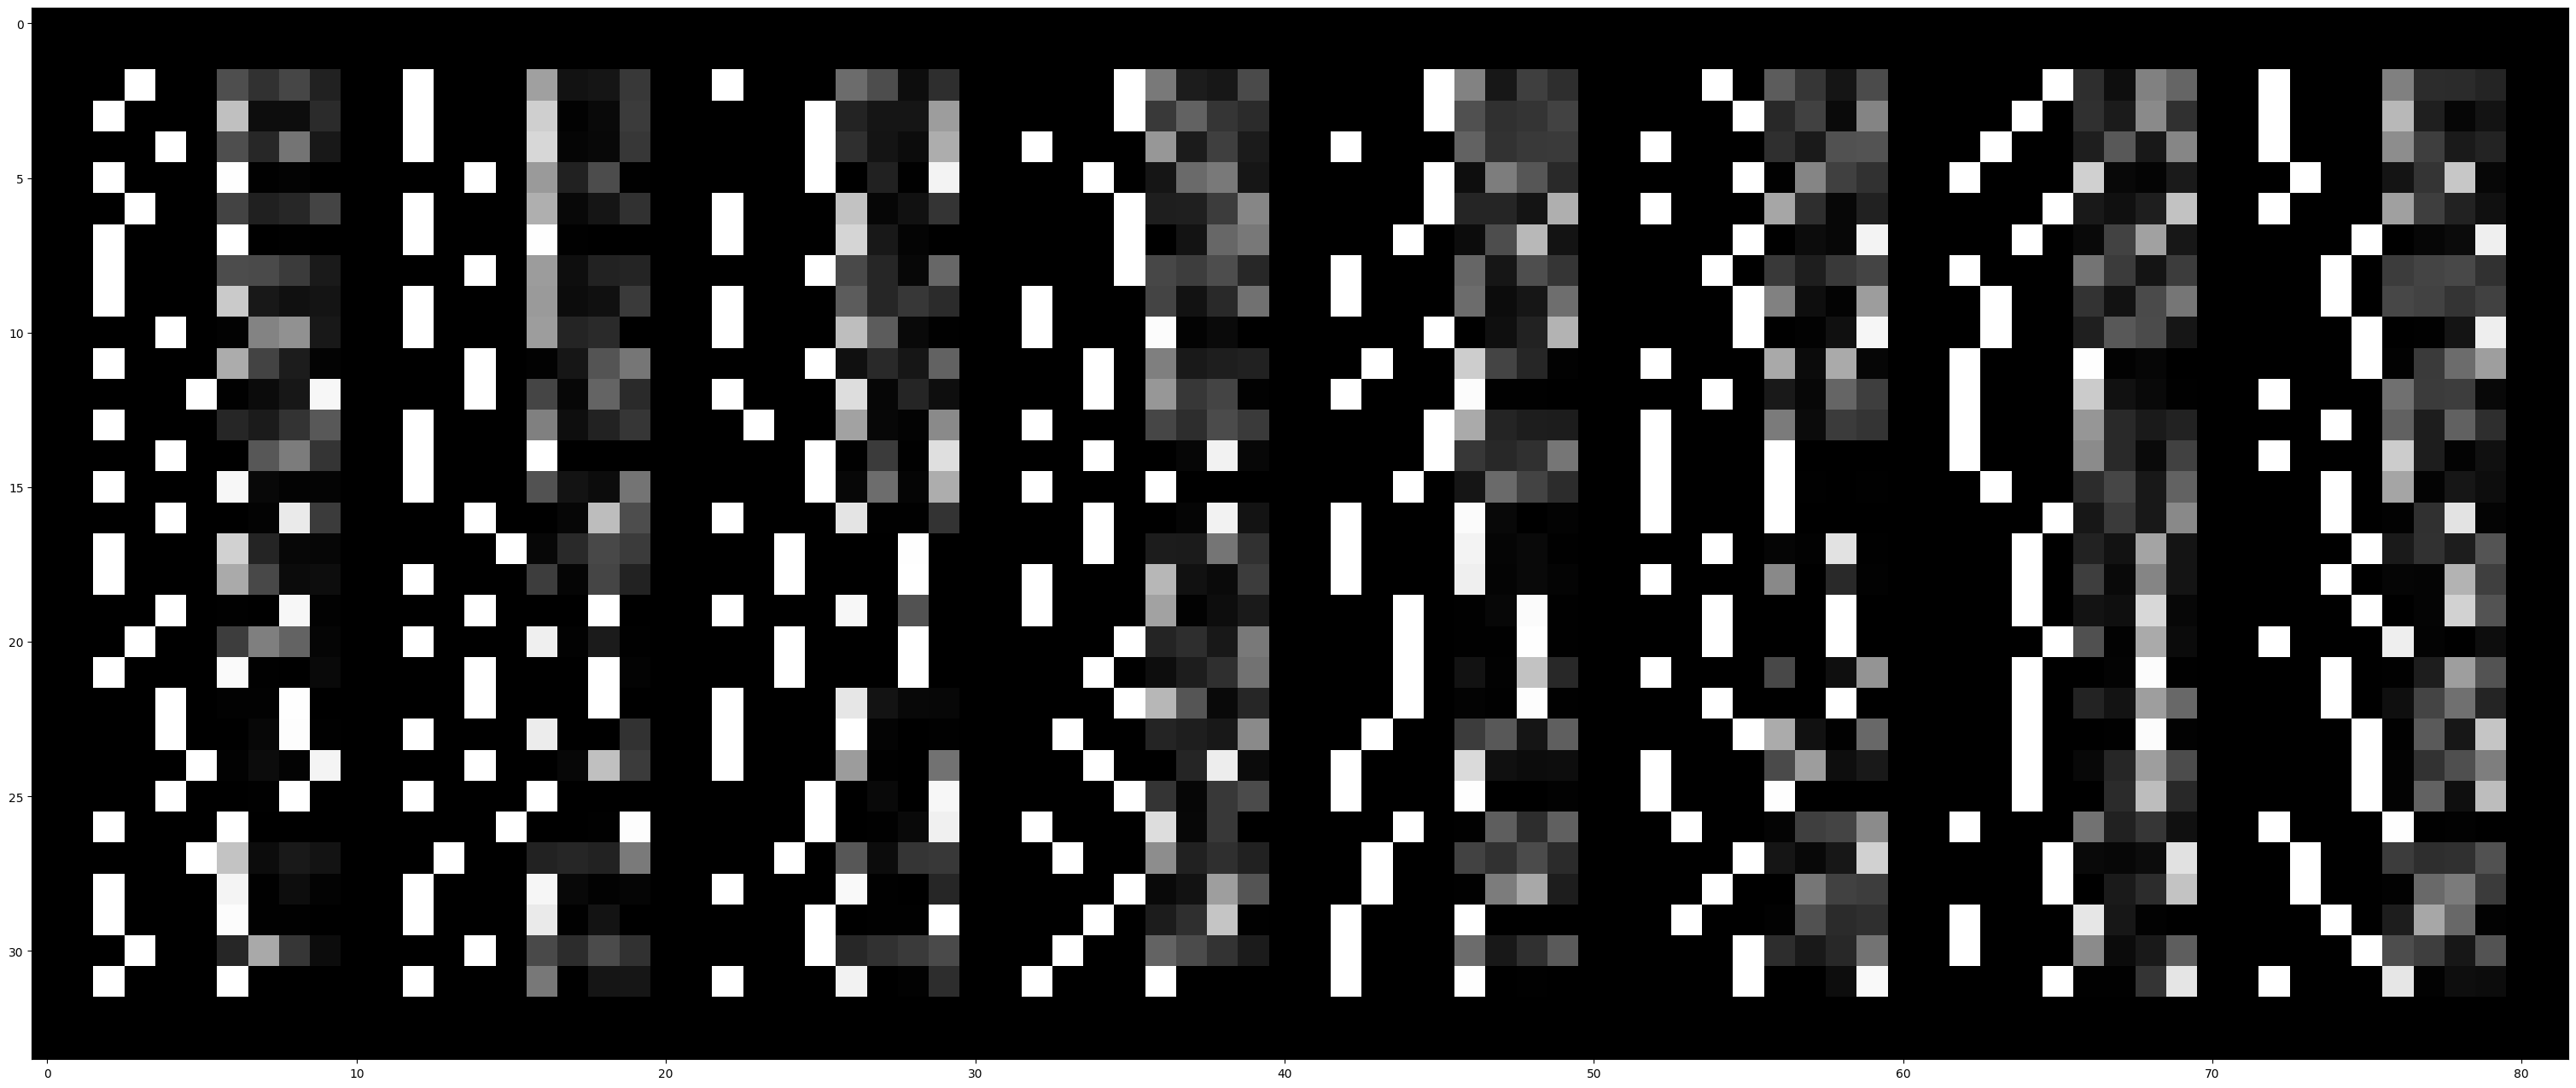

Epoch[52/100], Step [10/567], Reconst Loss: 292.6270, KL Div: 139.9489
Epoch[52/100], Step [20/567], Reconst Loss: 323.2959, KL Div: 129.8024
Epoch[52/100], Step [30/567], Reconst Loss: 289.9458, KL Div: 130.6602
Epoch[52/100], Step [40/567], Reconst Loss: 268.7936, KL Div: 140.0710
Epoch[52/100], Step [50/567], Reconst Loss: 295.8392, KL Div: 135.6744
Epoch[52/100], Step [60/567], Reconst Loss: 287.0561, KL Div: 123.0618
Epoch[52/100], Step [70/567], Reconst Loss: 238.6025, KL Div: 140.4480
Epoch[52/100], Step [80/567], Reconst Loss: 312.5414, KL Div: 131.9754
Epoch[52/100], Step [90/567], Reconst Loss: 303.8895, KL Div: 124.1302
Epoch[52/100], Step [100/567], Reconst Loss: 300.0103, KL Div: 133.1749
Epoch[52/100], Step [110/567], Reconst Loss: 289.4924, KL Div: 135.6618
Epoch[52/100], Step [120/567], Reconst Loss: 288.6707, KL Div: 139.2244
Epoch[52/100], Step [130/567], Reconst Loss: 316.5803, KL Div: 123.8515
Epoch[52/100], Step [140/567], Reconst Loss: 309.2812, KL Div: 130.4242
E

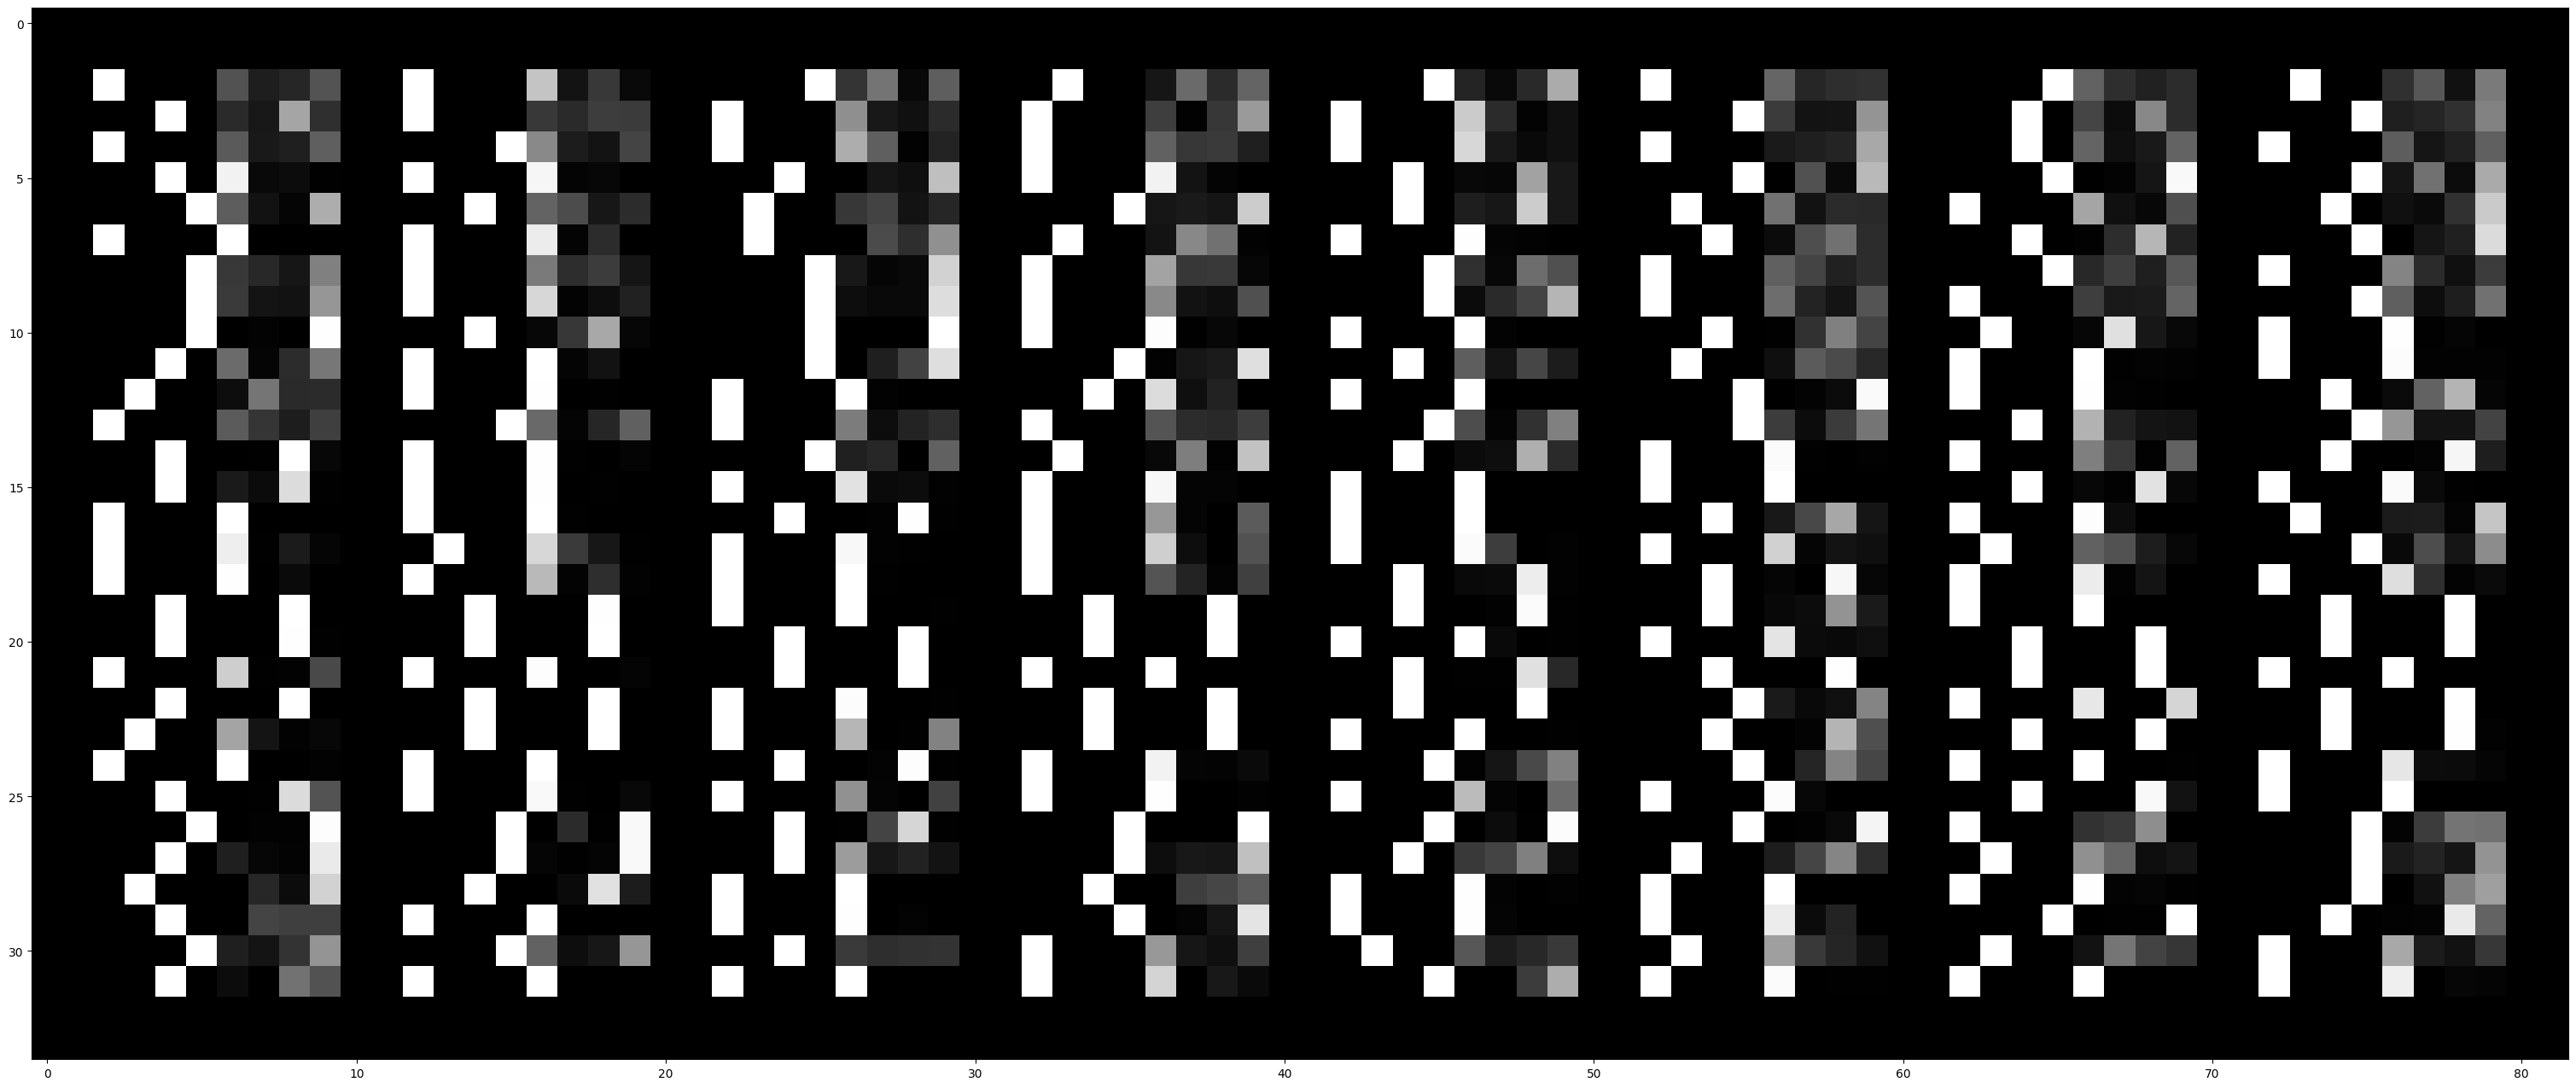

Epoch[77/100], Step [10/567], Reconst Loss: 280.5522, KL Div: 147.0479
Epoch[77/100], Step [20/567], Reconst Loss: 273.7539, KL Div: 144.6424
Epoch[77/100], Step [30/567], Reconst Loss: 266.8147, KL Div: 150.0301
Epoch[77/100], Step [40/567], Reconst Loss: 291.9138, KL Div: 151.8467
Epoch[77/100], Step [50/567], Reconst Loss: 230.3854, KL Div: 163.2489
Epoch[77/100], Step [60/567], Reconst Loss: 269.8766, KL Div: 154.0474
Epoch[77/100], Step [70/567], Reconst Loss: 280.7082, KL Div: 145.7045
Epoch[77/100], Step [80/567], Reconst Loss: 303.0821, KL Div: 149.4361
Epoch[77/100], Step [90/567], Reconst Loss: 232.1092, KL Div: 154.9143
Epoch[77/100], Step [100/567], Reconst Loss: 242.1481, KL Div: 151.3462
Epoch[77/100], Step [110/567], Reconst Loss: 268.0985, KL Div: 146.0336
Epoch[77/100], Step [120/567], Reconst Loss: 234.1405, KL Div: 158.5188
Epoch[77/100], Step [130/567], Reconst Loss: 283.8993, KL Div: 150.3474
Epoch[77/100], Step [140/567], Reconst Loss: 285.2997, KL Div: 148.1785
E

In [15]:
# Trans = transforms.Resize([4,30])
for epoch in range(num_epochs):
    # for i, (x,_) in enumerate(data_loader):
    for i, x in enumerate(data_loader):
        # print(i)

        # 获取样本，并前向传播
        # print("x:",x)
        # plt.imshow(x[0])
        # break
        # x = Trans(x)
        # print("x shape:",x.shape)
        x = x.to(device).view(-1, image_size)
        # print("x.shape after viewed:",x.shape)
        x_reconst, mu, log_var = model(x)
        
        # 计算重构损失和KL散度（KL散度用于衡量两种分布的相似程度）
        # KL散度的计算可以参考论文或者文章开头的链接
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # 反向传播和优化
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

    if (epoch - 1) % 25 == 0:
        # 利用训练的模型进行测试
        with torch.no_grad():
            # 随机生成的图像
            z = torch.randn(batch_size, z_dim).to(device)
            out = model.decode(z).view(-1, 1, 30, 4)
            print(epoch+1)
            save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))

            # 重构的图像
            out, _, _ = model(x)
            x_concat = torch.cat([x.view(-1, 1, 30, 4), out.view(-1, 1, 30, 4)], dim=3)
            
            save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))
            Image = mpimg.imread('samples/reconst-{}.png'.format(epoch+1))
            print(Image.shape)
            plt.figure(figsize= (40,16))
            plt.imshow(Image) # 显示图片
            # plt.axis('off') # 不显示坐标轴
            plt.show()



(34, 82, 3)


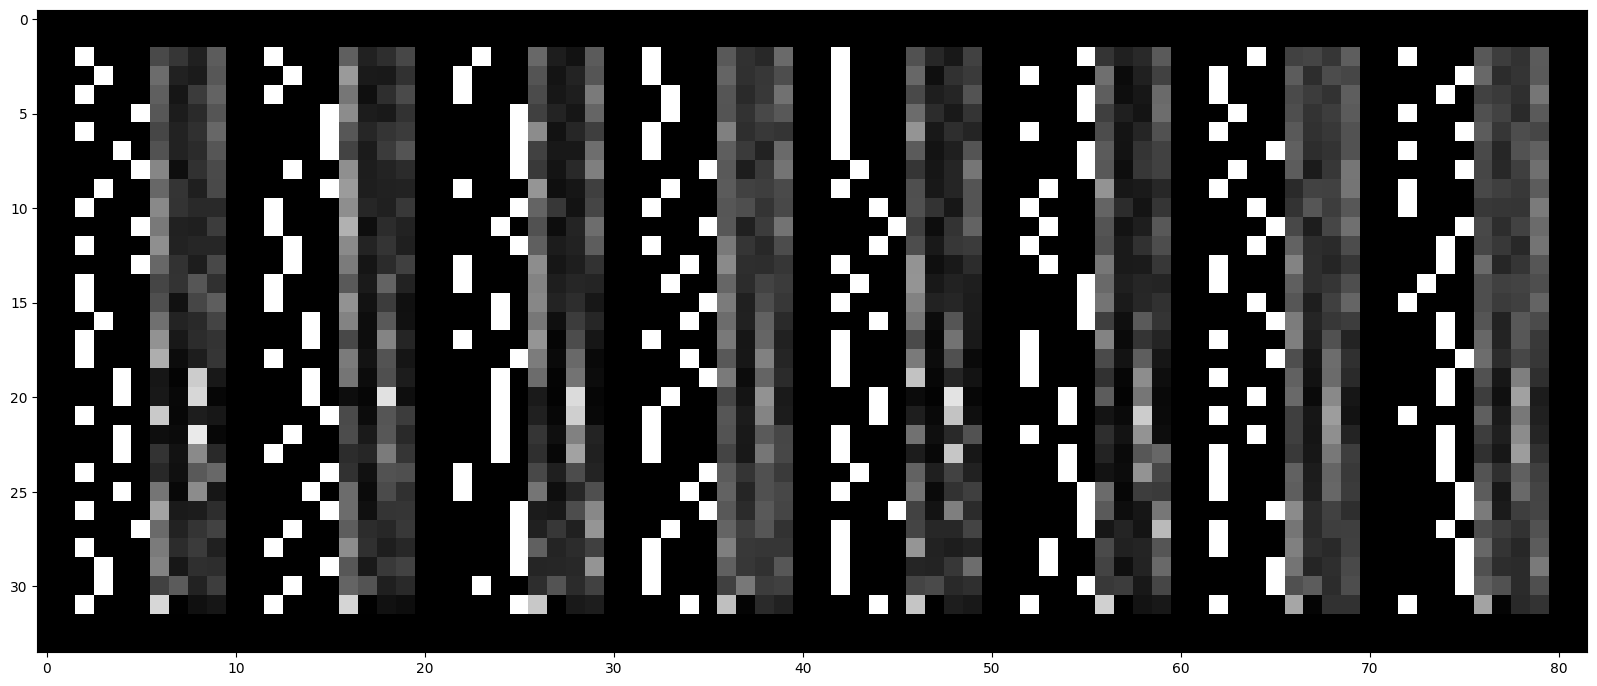

In [16]:

reconsPath = 'samples/reconst-1.png'
Image = mpimg.imread(reconsPath)
print(Image.shape)
plt.figure(figsize= (20,16))
plt.imshow(Image) # 显示图片
# plt.axis('off') # 不显示坐标轴
plt.show()

In [17]:
# 利用训练的模型进行测试
seqs = []
# for times in range(1000):
for i, x in enumerate(data_loader):
  with torch.no_grad():
      # 随机生成的图像
      x = x.to(device).view(-1, image_size)
      
      # out = model.decode(z).view(-1, 1, 30, 4)
      # seqs = []
      # for i in out:
      #   tmp = oh2seq(i.cpu(),invcharmap)
      #   seqs.append(tmp)
      # print(epoch+1)
      # save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
      # Image = mpimg.imread('samples/sampled-{}.png'.format(epoch+1))
      # print(Image.shape)
      # plt.figure(figsize= (20,16))
      # plt.imshow(Image) # 显示图片
      # # plt.axis('off') # 不显示坐标轴
      # plt.show()

    # # 重构的图像
      out, _, _ = model(x.to(device))
      out = out.view(-1, 1, 30, 4)
      for i in out:
        # print(out)
        tmp = oh2seq(i.cpu(),invcharmap)
        seqs.append(tmp)
    # x_concat = torch.cat([x.view(-1, 1, 30, 4), out.view(-1, 1, 30, 4)], dim=3)
    
    # save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))
    # Image = mpimg.imread('samples/reconst-{}.png'.format(epoch+1))
    # print(Image.shape)
    # plt.figure(figsize= (40,16))
    # plt.imshow(Image) # 显示图片
    # # plt.axis('off') # 不显示坐标轴
    # plt.show()

In [18]:
print(seqs)

[['TTGAACAAGCATATAAAAGGGAGATCAATA'], ['ACAAAAAATGAAGGAGAGGAGCTGCTTTCA'], ['TTAAATTACAAAGGAAGGAGGCGAAAAACA'], ['TGAAACAAAAAAAAAGGGGGAATTCGAATA'], ['GATTAATAACAAACTAGGAGGGGAGAGATA'], ['AGAATACAAAGTATAGAGGAGGGAATTAAA'], ['CTTCATTTAATATGAAAGGAGACTTTCTTA'], ['GGAGTCTTTTTCTAAAAGAGGTGGAAGCAA'], ['TTTATTAAAAAAACTGAAAGGAAGCTTTTA'], ['GGGAGACTGATTTTAGGGAGGGGATCAAAA'], ['TTATAAAGGTGTCAGAGGAGAGGAAATTTA'], ['AAAAAGATCTTTTTTTCGGAGGTGATCCCA'], ['TCATTTTTGAAAACAAAGGAGAAAATCACG'], ['AAAAATAAAAAATGAAAGGAGGAGATGCCA'], ['ATTCTCTAGTGTAAGGAAGTGAACCTGATT'], ['AAAATCATTGAAGAAGGAGGGTATGAAAAA'], ['AAAAAAAAAGGGAAAAAGGAGGTGAAGGAA'], ['GGAATACGCACAGAAGGAGATTTTAATCAA'], ['ATAACTTTTTTTAGGGAGGATTTTGTGACA'], ['AATCACAATTATTAGAGGAGAGAAGATAAA'], ['GTAACGTTTTAAAGGAGAGGTGAAAGAATA'], ['AGAGAAATTTTAGTATAGGGGGGATATTTT'], ['ATTATCTTTTTGAGAAGGAGGGAATCAGAA'], ['GAAGCAGCCGATTCATCAGCAGGATGTGAA'], ['CAAAAAAACTGATCAAAAAGGGGATTTAAT'], ['AAAAAGAACGAATGCGGAGTGGATTCCTCA'], ['AATGAGAACCGCCATTCCTATATCGTTATT'], ['CAAGAAAATTAATAAAGGAGGTGAT

In [19]:
#重构序列输出
print(len(seqs))

4536


In [20]:
#随机生成
with torch.no_grad():
    z = torch.randn(batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 30, 4)
    out = out.view(-1, 1, 30, 4)
    for i in out:
      # print(out)
        tmp = oh2seq(i.cpu(),invcharmap)
        print(tmp)

['ATTTATAAAGAATATAGGAGGCATGAGAAA']
['AATGAAGAGATAATGGGAGGTTTTCTACAA']
['TAAGTTGTATATAAAATGGAGTGAAACTAA']
['TTACAGAGGAAAAATATGAAGTGAAGGTAG']
['TAAAACAAGAAAGAAGGGGTATTGAATAAA']
['AAAAAGGATTGTAAGGGTTTTAATGTGGAT']
['GAAATTTAAAAAAGTCAGGAGGTTGAAATT']
['AAAGTAAGGAAAAGAGGTTTGAACCTCAAA']


In [21]:
with open('recons.txt','w') as f:
  for i in seqs:
    f.write(i[0]+'\n')


In [22]:
torch.save(model.state_dict(), 'save889.pth')